In [5]:
# /content/pacemakerClean2.csv
#!pip install datasets

In [6]:
# Pacemaker Failure Analysis with BioBERT Fine-Tuning

import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
from datasets import Dataset
import torch
from sklearn.model_selection import train_test_split

In [7]:
# Step 1: Load and clean data
file_path = "/content/pacemaker50K.csv"
df = pd.read_csv(file_path, dtype=str, low_memory=False)
df = df[df["FOI_TEXT"].notna()]
df = df[df["ADVERSE_EVENT_FLAG"].isin(['Y', 'N', 'True', 'False', True, False])]
df["FOI_TEXT"] = df["FOI_TEXT"].astype(str)
df["ADVERSE_EVENT_FLAG"] = df["ADVERSE_EVENT_FLAG"].map({'Y': 1, 'N': 0, 'True': 1, 'False': 0, True: 1, False: 0})
df = df[df["FOI_TEXT"].str.strip() != ""]

In [8]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

def tokenize_function(example):
    return tokenizer(example["FOI_TEXT"], truncation=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [9]:
train_df, test_df = train_test_split(
    df[["FOI_TEXT", "ADVERSE_EVENT_FLAG"]].rename(columns={"ADVERSE_EVENT_FLAG": "label"}),
    test_size=0.2,
    stratify=df["ADVERSE_EVENT_FLAG"],
    random_state=42
)

# Convert to HuggingFace Datasets
train_dataset = Dataset.from_pandas(train_df.reset_index(drop=True))
test_dataset = Dataset.from_pandas(test_df.reset_index(drop=True))

# Combine into DatasetDict
from datasets import DatasetDict
dataset = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})
tokenized_dataset = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [10]:
# Step 4: Load BioBERT for Sequence Classification
# model = AutoModelForSequenceClassification.from_pretrained("dmis-lab/biobert-base-cased-v1.1", num_labels=2)
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
# !pip install transformers --upgrade

In [12]:
# training_args = TrainingArguments(
#     output_dir="./results",
#     evaluation_strategy="steps",  # Evaluate and save at the same strategy
#     eval_steps=100,  # Evaluate every 100 training steps
#     save_steps=100,  # Save every 100 training steps
#     save_strategy="steps",  # Save based on steps instead of epoch
#     learning_rate=2e-5,
#     per_device_train_batch_size=8,
#     per_device_eval_batch_size=8,
#     num_train_epochs=3,
#     weight_decay=0.01,
#     logging_dir="./logs",
#     logging_steps=10,
#     load_best_model_at_end=True,
# )

training_args = TrainingArguments(
    output_dir="./results",
    do_train=True,
    do_eval=True,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    logging_dir="./logs"
)

In [13]:
# Step 6: Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

<ipython-input-13-8ab2019a9060>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [14]:
# Step 7: Train the model
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: 1nh18cs168-samridhigupta (1nh18cs168-samridhigupta-university-of-adelaide) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
500,0.616900
1000,0.584500
1500,0.661000
2000,0.657200
2500,0.656200
3000,0.651600
3500,0.649300
4000,0.660800
4500,0.653900
5000,0.658600


TrainOutput(global_step=15000, training_loss=0.6489226114908854, metrics={'train_runtime': 10791.6995, 'train_samples_per_second': 11.12, 'train_steps_per_second': 1.39, 'total_flos': 3.006882062865936e+16, 'train_loss': 0.6489226114908854, 'epoch': 3.0})


Classification Report (BERT):

              precision    recall  f1-score   support

           0       0.65      1.00      0.79      6531
           1       0.00      0.00      0.00      3469

    accuracy                           0.65     10000
   macro avg       0.33      0.50      0.40     10000
weighted avg       0.43      0.65      0.52     10000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


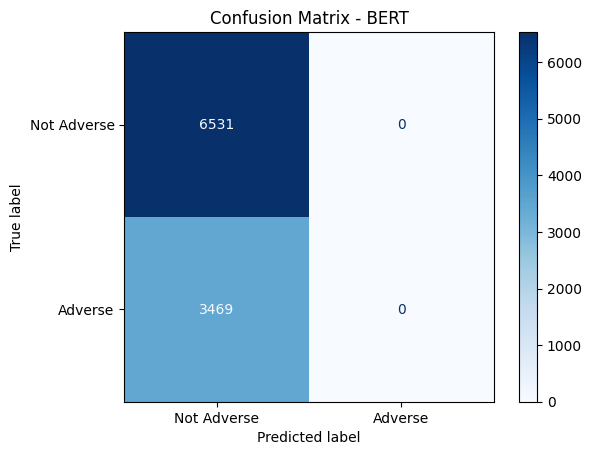


 Model saved to ./fine_tuned_biobert


In [16]:
# Step 8: Evaluate the model
predictions = trainer.predict(tokenized_dataset["test"])
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

print("\nClassification Report (BERT):\n")
print(classification_report(labels, preds))

# Confusion matrix
cm = confusion_matrix(labels, preds)
ConfusionMatrixDisplay(cm, display_labels=["Not Adverse", "Adverse"]).plot(cmap="Blues")
plt.title("Confusion Matrix - BERT")
plt.show()

# Optional: Save fine-tuned model
model.save_pretrained("./fine_tuned_biobert")
tokenizer.save_pretrained("./fine_tuned_biobert")
print("\n Model saved to ./fine_tuned_biobert")
